In [12]:
# importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import warnings
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None 

**Recommender System:**
> The goal of the recommender system is to generate meaningful recommendations to a collection of users for items or products that might interest them. There are five recommender system types: content-based filtering, collaborative filtering, hybrid models, most popular items, and association and market basket analysis. I will use a content-based filtering method to provide user movie recommendations in this project. 

In [13]:
# loading movies dataset into dataframe
movies_df = pd.read_csv('movies.csv')

# loading ratings dataset into dataframe
ratings_df = pd.read_csv('ratings.csv')

# loading links dataset into dataframe
links_df = pd.read_csv('links.csv')

# loading links dataset into dataframe
tags_df = pd.read_csv('tags.csv')

# pring the shape of the dataframes

print(f"Movies_dataset= Rows: {movies_df.shape[0]} and columns: {movies_df.shape[1]}")

print(f"Ratings_dataset= Rows: {ratings_df.shape[0]} and columns: {ratings_df.shape[1]}")

print(f"links_dataset= Rows: {links_df.shape[0]} and columns: {links_df.shape[1]}")

print(f"tags_dataset= Rows: {tags_df.shape[0]} and columns: {tags_df.shape[1]}")

# display first few rows
print("\nMovies:")
display(movies_df.head(3))
print("\nRatings:")
display(ratings_df.head(3))
print("\nLinks:")
display(links_df.head(3))
print("\nTags:")
display(tags_df.head(3))

Movies_dataset= Rows: 9742 and columns: 3
Ratings_dataset= Rows: 100836 and columns: 4
links_dataset= Rows: 9742 and columns: 3
tags_dataset= Rows: 3683 and columns: 4

Movies:


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance



Ratings:


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224



Links:


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0



Tags:


,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992


**Comments:**
> The above dataset shows genres, ratings, or tags are a good feature for content-based filtering methods. In this project, I use the genre feature to display the movie recommendation. I will be using only the movie_df for this project.

**Data Preparation:**

In [14]:
# creating function to clean the movie title
def clean_movie_title(title):
    return re.sub('\(.*?\)',"",title).strip()

def get_movie_year(title):
     return  title[title.find("(")+1:title.find(")")]

# applying the functions to extract new features
movies_df['cleaned_title'] = movies_df['title'].apply(clean_movie_title)
movies_df['year'] = movies_df['title'].apply(get_movie_year)

#  display few records of cleaned movie title and year
display( movies_df[['cleaned_title','year']].head(3))

# convert year to numeric. if any non numeric value found fill with 0
movies_df['year'] = pd.to_numeric(movies_df['year'], errors='coerce')\
.fillna(0).astype(np.int64)

,cleaned_title,year
0,Toy Story,1995
1,Jumanji,1995
2,Grumpier Old Men,1995


**Comments:**
> The movie title has a year in it. It will be inconvenient for users to search for movies with years in the data. Hence, I removed the year from the title so users can get recommendations just by passing the title. I also created new columns for the year and converted them to numbers.

In [15]:
movies_df = movies_df[movies_df['genres']!='(no genres listed)']

# creating function to clean the genre title
def clean_movie_genre(genre):
    return ' '.join(map(str,genre.split('|')))

# applying the function
movies_df['cleaned_genres'] = movies_df['genres'].apply(clean_movie_genre).fillna("")

# display few records of cleaned genre of each movie
movies_df['cleaned_genres'].head()


0    Adventure Animation Children Comedy Fantasy
1                     Adventure Children Fantasy
2                                 Comedy Romance
3                           Comedy Drama Romance
4                                         Comedy
Name: cleaned_genres, dtype: object

**Comments:**
> There are 34  movies recorded as  '(no genres listed)' genre. These are not useful for the recommendation systems. I dropped these records. The genre is pipe-delimited. I use genre to create a movie recommendation system. It is essential to clean the genre. I cleaned the genre and converted it to string.

**Exploratory Data Analysis:**

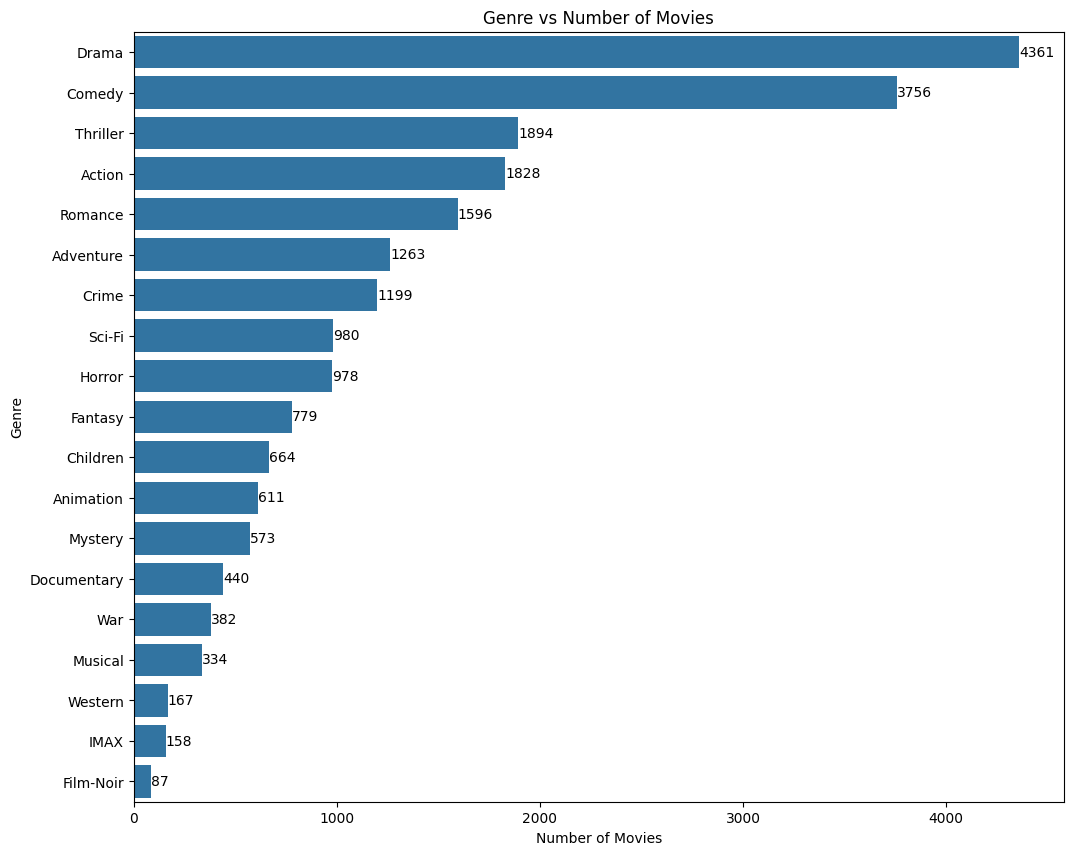

In [16]:
# find the genre term frequency
term_frequency = movies_df['genres'].str.split('|',expand=True).stack().value_counts()
# Setting the figure size
plt.figure(figsize=(12, 10)) 
# plot bar plot
ax = sns.barplot(y=term_frequency.index, x= term_frequency.values)

# set the titles and labesl
ax.set_ylabel('Genre')    
ax.set_xlabel('Number of Movies')
plt.title('Genre vs Number of Movies')
ax.bar_label(ax.containers[0] )

# show the plot 
plt.show()

**Comments:**
> The above bar chart shows that  Drama, comedy, thriller, action, and romance are the top 5 genres. The bottom five are film-noir, IMAX, western, musical, and war.

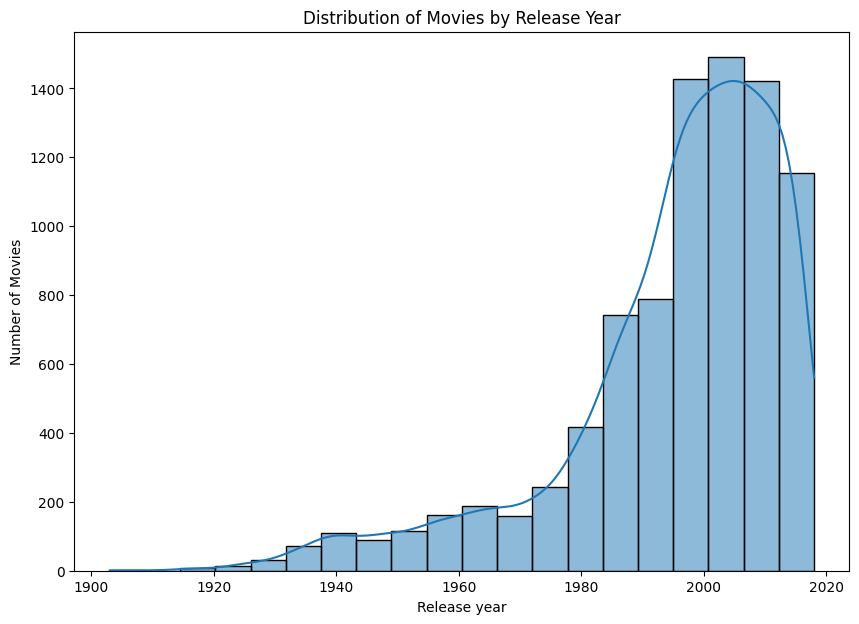

In [17]:
# Plotting the histogram for movie release years
plt.figure(figsize=(10, 7))

# plot histogram of movie release
sns.histplot(data=movies_df[movies_df['year'] > 1900 ], x='year', kde=True, bins=20)
plt.title('Distribution of Movies by Release Year') 
plt.xlabel('Release year')  
plt.ylabel('Number of Movies') 

plt.show()

**Comments:**
> The above histogram shows that the data is negatively skewed. There are a lot of movies released after 1995.

**Model:**

In [18]:
# creating the instance of TfidfVectorizer
tfidf_vectorizer  = TfidfVectorizer()

# fit and transform the genre and it return document-term matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(movies_df["cleaned_genres"])

# print the shape
print(tfidf_matrix.shape)

# display few records of the matrix
display(pd.DataFrame(tfidf_matrix.todense()).iloc[:5])

# print the feature names
print(tfidf_vectorizer.get_feature_names_out())

(9708, 21)


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.0,0.416804,0.516288,0.504896,0.267388,0.0,0.0,0.000000,0.483017,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.512293,0.000000,0.620567,0.000000,0.0,0.0,0.000000,0.593677,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.000000,0.000000,0.570705,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.821155,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.000000,0.000000,0.504886,0.0,0.0,0.466216,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.726452,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


['action' 'adventure' 'animation' 'children' 'comedy' 'crime'
 'documentary' 'drama' 'fantasy' 'fi' 'film' 'horror' 'imax' 'musical'
 'mystery' 'noir' 'romance' 'sci' 'thriller' 'war' 'western']


**Comments:**
> TfidfVectorizer transforms the text into a meaningful representation of integers or numbers. TF-IDF Vectorizer measures the originality of a word by comparing the number of times a word appears in the document with the number of documents the word occurs in.

In [19]:
# Compute similarity
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

# print the shape
print(cosine_sim.shape)

# display few
cosine_sim[:4,:4]

(9708, 9708)


array([[1.        , 0.8136036 , 0.15259961, 0.13500041],
       [0.8136036 , 1.        , 0.        , 0.        ],
       [0.15259961, 0.        , 1.        , 0.88467078],
       [0.13500041, 0.        , 0.88467078, 1.        ]])

**Comments:**
> Cosine similarity is a measure of similarity between two non-zero vectors. I used the cosine similarity to compare the similarity of two documents. 

In [20]:
# creating index of the movie
title_indices = pd.Series(movies_df.index,\
                          index=movies_df["cleaned_title"]).drop_duplicates()

# print few 
print(title_indices.head())

cleaned_title
Toy Story                      0
Jumanji                        1
Grumpier Old Men               2
Waiting to Exhale              3
Father of the Bride Part II    4
dtype: int64


In [21]:
'''Creating the function to return movie recommendations. 
This function takes the movie title as an argument and returns
the top 10 movie recommendations. This function
uses a cosine similarity score to provide the recommendations.'''

def get_top_ten_movie_recommendations_based_on_genre(title):
# get the index of the title    
    idx = title_indices[title]
# get  similarty score, sort the score in descending order and get top 10 scores
    top_ten_sim_scores = sorted(list(enumerate(cosine_sim[idx])),\
                                key=lambda x: x[1], reverse=True)[0:11]
# get the indices of top 10 movies
    movie_indices = [i[0] for i in top_ten_sim_scores if i[0] != idx]
# return top 10 recommended movies
    for movie in movies_df["cleaned_title"].iloc[movie_indices].values:
        print(movie)
        

In [22]:
# Getting top 10 recommendations for the movie Turbo
get_top_ten_movie_recommendations_based_on_genre('Turbo')

Toy Story
Antz
Toy Story 2
Adventures of Rocky and Bullwinkle, The
Emperor's New Groove, The
Monsters, Inc.
Wild, The
Shrek the Third
Tale of Despereaux, The
Asterix and the Vikings


**Reference:**
> https://www.analyticsvidhya.com/blog/2015/08/beginners-guide-learn-content-based-recommender-systems/